# DSS Thesis - Koen de Bonth

### Import packages

In [4]:
import os
import sys
from pathlib import Path

# Get the current working directory
current_dir = os.getcwd()

# Set the root directory to the parent of the current directory
root_dir = Path(current_dir).parent

# Add the root directory to sys.path so Python can find the utils module
sys.path.append(str(root_dir))
print(f"Added {root_dir} to Python path")


Added c:\Thesis\DSS_Thesis_CNC\DSS_Thesis_CNC to Python path


In [17]:
from utils import data_loader_utils
import itertools 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import numpy as np
from scipy import signal

### Loading and Preparing Data

In [18]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]

path_to_dataset = os.path.join(root_dir, "data")

X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
    X_data.extend(data_list)
    y_data.extend(data_label)


### Metadata Extraction

In [19]:
# List to store metadata about each h5 file
file_metadata = []

# Sampling rate in Hz for the measurements
SAMPLING_RATE = 2000  

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    if os.path.exists(data_path):
        for file in os.listdir(data_path):
            if file.endswith('.h5'):
                fullpath = os.path.join(data_path, file)
                with h5py.File(fullpath, 'r') as f:
                    dataset_name = list(f.keys())[0]
                    dataset = f[dataset_name]
                    
                    file_metadata.append({
                        'machine': machine,
                        'operation': process_name,
                        'class': label,
                        'measurements': dataset.shape[0],
                        'channels': dataset.shape[1] if len(dataset.shape) > 1 else 1,
                        'duration_sec': dataset.shape[0] / SAMPLING_RATE,  # Duration in seconds
                        'duration_min': dataset.shape[0] / SAMPLING_RATE / 60,  # Duration in minutes 
                        'file_size_mb': os.path.getsize(fullpath) / (1024 * 1024),
                        'month_created': file.split('_')[1],
                        'year_created': file.split('_')[2],
                        'full_path': fullpath
                    })

# Create dataframe with file metadata
df_measurement_files = pd.DataFrame(file_metadata)
# df_measurement_files.to_csv('export/measurement_files_metadata.csv', index=False)

# display(df_measurement_files)

### Feature Extraction

In [28]:
x = X_data

### Exploratory Data Analysis (EDA)

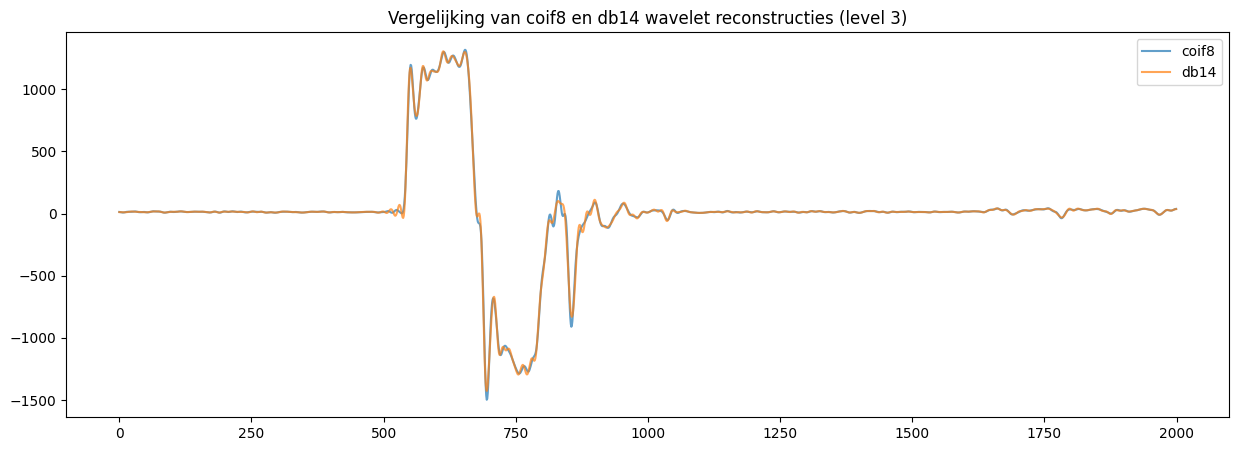


Samenvatting van de dataset:
Totaal aantal files: 1702

Gemiddelde duur per meting: 52.47 seconden
Standaard deviatie van duur: 30.25 seconden

Aantal kanalen per meting: {3: 1702}


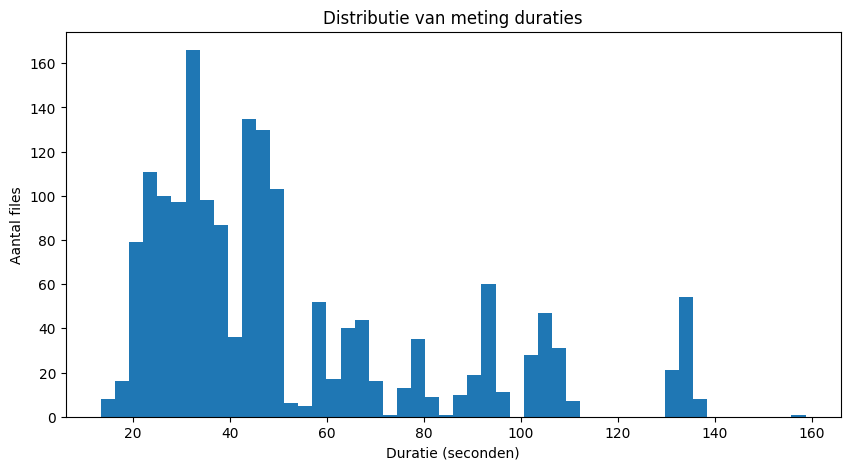

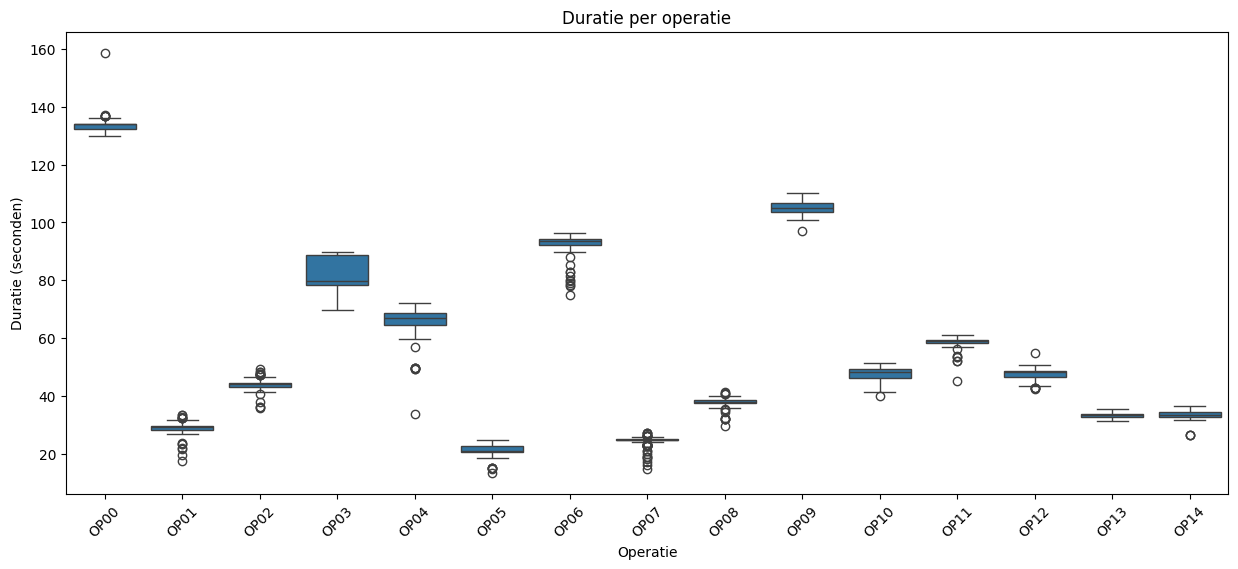

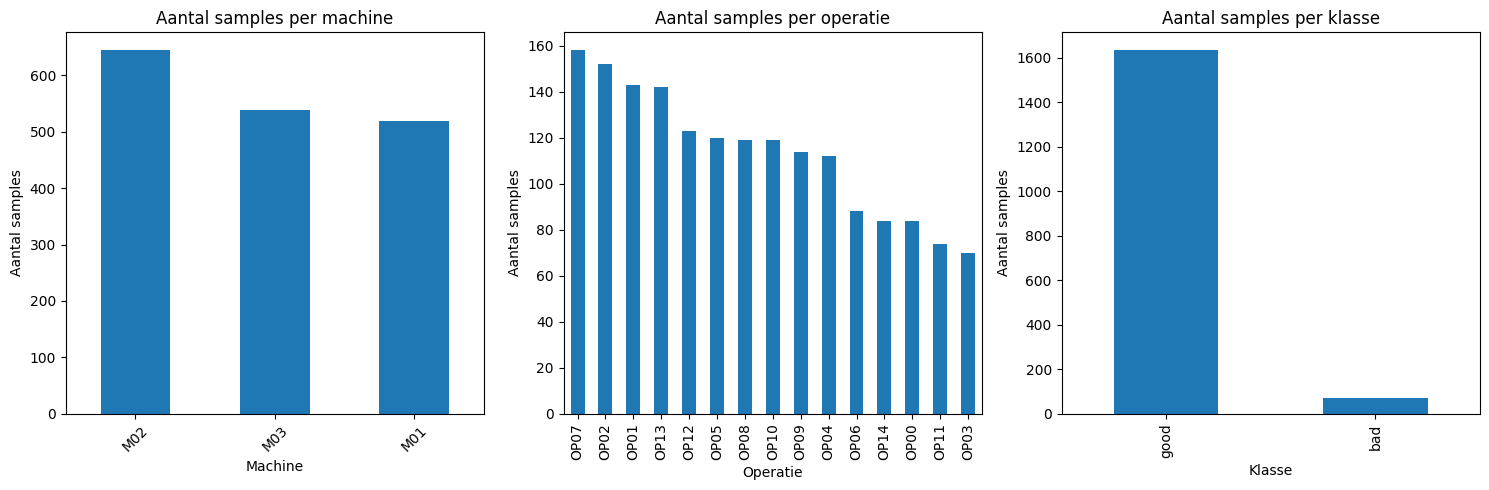


Dataset statistieken:
Totaal aantal samples: 1702

Verdeling per machine:
machine
M02    644
M03    539
M01    519
Name: count, dtype: int64

Verdeling per operatie:
operation
OP07    158
OP02    152
OP01    143
OP13    142
OP12    123
OP05    120
OP08    119
OP10    119
OP09    114
OP04    112
OP06     88
OP14     84
OP00     84
OP11     74
OP03     70
Name: count, dtype: int64

Verdeling per klasse:
class
good    1632
bad       70
Name: count, dtype: int64
mean: 104936.09870740306
std: 60507.87696581091
median: 87040.0


In [35]:
# Plot coif8 en db14 over elkaar voor vergelijking
plt.figure(figsize=(15, 5))

signal = x[100][:2000, 0]  # Gebruik zelfde signaal als hierboven

# Bereken wavelet decomposities
coif8_coeffs = pywt.wavedec(signal, wavelet='coif8', level=3)
db14_coeffs = pywt.wavedec(signal, wavelet='db14', level=3)

# Reconstrueer approximaties
coif8_reconstructed = pywt.waverec([coif8_coeffs[0]] + [None] * 3, 'coif8')
db14_reconstructed = pywt.waverec([db14_coeffs[0]] + [None] * 3, 'db14')

# Plot beide reconstructies over elkaar
plt.plot(coif8_reconstructed[:len(signal)], label='coif8', alpha=0.7)
plt.plot(db14_reconstructed[:len(signal)], label='db14', alpha=0.7)
plt.title("Vergelijking van coif8 en db14 wavelet reconstructies (level 3)")
plt.legend()
plt.show()

# Voeg wat nuttige analyses toe
print("\nSamenvatting van de dataset:")
print(f"Totaal aantal files: {len(df_measurement_files)}")
print(f"\nGemiddelde duur per meting: {df_measurement_files['duration_sec'].mean():.2f} seconden")
print(f"Standaard deviatie van duur: {df_measurement_files['duration_sec'].std():.2f} seconden")
print(f"\nAantal kanalen per meting: {df_measurement_files['channels'].value_counts().to_dict()}")

# Visualisatie van de duur van metingen
plt.figure(figsize=(10, 5))
plt.hist(df_measurement_files['duration_sec'], bins=50)
plt.title('Distributie van meting duraties')
plt.xlabel('Duratie (seconden)')
plt.ylabel('Aantal files')
plt.show()

# Boxplot van duur per operatie
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_measurement_files, x='operation', y='duration_sec')
plt.xticks(rotation=45)
plt.title('Duratie per operatie')
plt.xlabel('Operatie')
plt.ylabel('Duratie (seconden)')
plt.show()

# Maak een bar plot van de verdeling van de data over machines, operaties en klassen
import matplotlib.pyplot as plt

# Maak een figuur met subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot voor machine verdeling
df_measurement_files['machine'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Aantal samples per machine')
ax1.set_xlabel('Machine')
ax1.set_ylabel('Aantal samples')
ax1.tick_params(axis='x', rotation=45)

# Plot voor operatie verdeling 
df_measurement_files['operation'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Aantal samples per operatie')
ax2.set_xlabel('Operatie')
ax2.set_ylabel('Aantal samples')
ax2.tick_params(axis='x', rotation=45)

# Plot voor klasse verdeling
df_measurement_files['class'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Aantal samples per klasse')
ax3.set_xlabel('Klasse')
ax3.set_ylabel('Aantal samples')
ax3.tick_params(axis='x', rotation=45)

# Plot voor operatie verdeling 
df_measurement_files['operation'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Aantal samples per operatie')
ax2.set_xlabel('Operatie')
ax2.set_ylabel('Aantal samples')

# Plot voor klasse verdeling
df_measurement_files['class'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Aantal samples per klasse')
ax3.set_xlabel('Klasse')
ax3.set_ylabel('Aantal samples')

fig.tight_layout()
plt.show()

# Export the plot to a file
# fig.savefig('data_distribution.png')

# Print wat statistieken
print("\nDataset statistieken:")
print(f"Totaal aantal samples: {len(df_measurement_files)}")
print("\nVerdeling per machine:")
print(df_measurement_files['machine'].value_counts())
print("\nVerdeling per operatie:")
print(df_measurement_files['operation'].value_counts())
print("\nVerdeling per klasse:")
print(df_measurement_files['class'].value_counts())


print("mean:",df_measurement_files['measurements'].mean())
print("std:",df_measurement_files['measurements'].std())
print("median:",df_measurement_files['measurements'].median())